# Neural network 4 emotions

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, callbacks, activations, regularizers
import numpy as np

In [18]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [19]:
def plot_results(hist):
  fig, axs = plt.subplots(1, 2, figsize=(25, 8))
  axs[0].plot(hist.history['loss'], label='loss')
  axs[0].plot(hist.history['val_loss'], label='val_loss')
  axs[1].plot(hist.history['accuracy'], label='accuracy')
  axs[1].plot(hist.history['val_accuracy'], label='val_accuracy')

  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Loss')
  axs[0].legend()
  axs[0].grid(True)

  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Accuracy')
  axs[1].legend()
  axs[1].grid(True)

Load and scale data
Change labels to numerical values
Remove highly correlated features
Create train, validation and test splits

In [20]:
# loading the data
dataset = pd.read_csv('../dataset/labeled_4_combined_dataset.csv', index_col=0)

# getting unique labels
unique_labels = np.unique(dataset['LABEL'])
unique_labels

array(['Ekscytacja', 'Odprezenie', 'Smutek', 'Zlosc'], dtype=object)

In [21]:
# changing labels to numerical
dataset.loc[dataset['LABEL'] == 'Ekscytacja', 'LABEL'] = 0.0
dataset.loc[dataset['LABEL'] == 'Odprezenie', 'LABEL'] = 1.0
dataset.loc[dataset['LABEL'] == 'Smutek', 'LABEL'] = 2.0
dataset.loc[dataset['LABEL'] == 'Zlosc', 'LABEL'] = 3.0

In [22]:
# separating data and labels
data = dataset.iloc[:, :-4]
labels = dataset.iloc[:, -1]
labels = np.asarray(labels).astype('float32')

# scaling the data
data_scaled = StandardScaler().fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

# creating train, validation and test splits
d, data_test, l, labels_test = train_test_split(data_scaled, labels, test_size=0.1, random_state=0, stratify=labels)
data_train, data_validation, labels_train, labels_validation = train_test_split(d, l, test_size=0.1, random_state=0, stratify=l)

In [23]:
BaseDense = partial(
    layers.Dense,
    kernel_initializer="he_normal",
    kernel_regularizer=tf.keras.regularizers.l2(0.001),
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=96, restore_best_weights=True)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=32)

# ECG

Extract only ecg related features

In [24]:
ecg_columns = [col for col in data.columns if 'ECG' in col or 'HRV' in col]

ecg_data_train = data_train[ecg_columns]
ecg_data_validation = data_validation[ecg_columns]
ecg_data_test = data_test[ecg_columns]

Define the model and train it

Epoch 1/1000
134/134 [==============================] - 1s 6ms/step - loss: 2.8341 - accuracy: 0.3110 - val_loss: 2.3938 - val_accuracy: 0.3207 - lr: 0.1000
Epoch 2/1000
134/134 [==============================] - 0s 4ms/step - loss: 2.1603 - accuracy: 0.3123 - val_loss: 1.9649 - val_accuracy: 0.2902 - lr: 0.1000
Epoch 3/1000
134/134 [==============================] - 1s 4ms/step - loss: 1.8233 - accuracy: 0.3174 - val_loss: 1.7136 - val_accuracy: 0.3176 - lr: 0.1000
Epoch 4/1000
134/134 [==============================] - 0s 4ms/step - loss: 1.6285 - accuracy: 0.3110 - val_loss: 1.5659 - val_accuracy: 0.3155 - lr: 0.1000
Epoch 5/1000
134/134 [==============================] - 0s 4ms/step - loss: 1.5150 - accuracy: 0.3161 - val_loss: 1.4761 - val_accuracy: 0.3218 - lr: 0.1000
Epoch 6/1000
134/134 [==============================] - 0s 4ms/step - loss: 1.4500 - accuracy: 0.3154 - val_loss: 1.4342 - val_accuracy: 0.3207 - lr: 0.1000
Epoch 7/1000
134/134 [==============================] - 0s

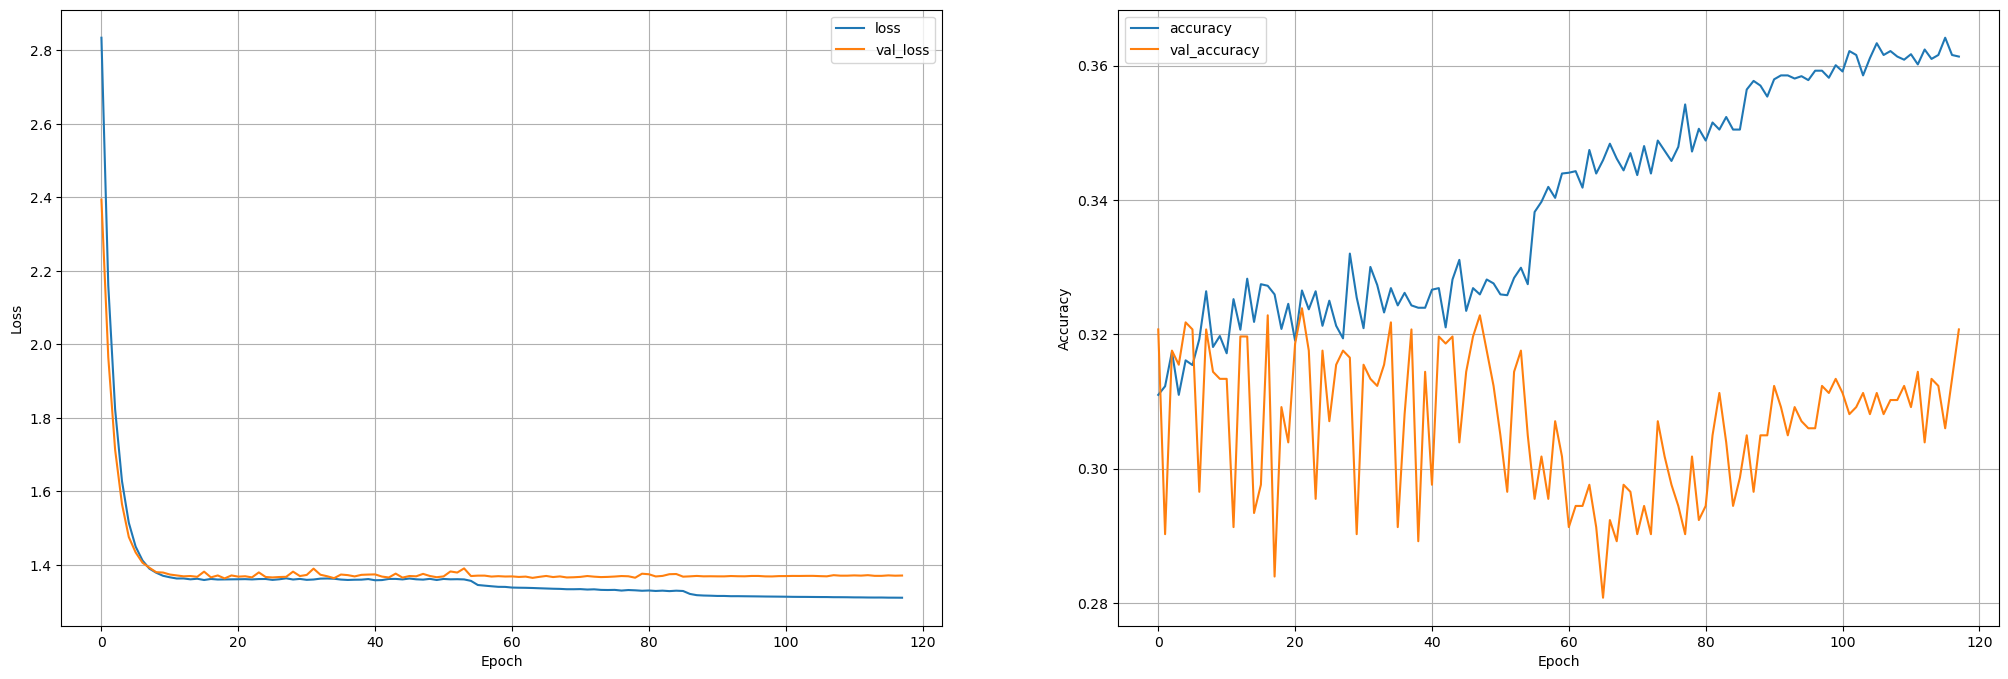

In [25]:
ecg_model = tf.keras.Sequential([
    BaseDense(256),
    layers.ReLU(),
    BaseDense(256),
    layers.ReLU(),
    BaseDense(256),
    layers.ReLU(),
    layers.Dense(4, activation='softmax')
])

ecg_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

h = ecg_model.fit(
    ecg_data_train,
    labels_train,
    epochs=1000,
    batch_size=64,
    validation_data=(ecg_data_validation, labels_validation),
    callbacks=[early_stop, reduce_lr_cb]
)

plot_results(h)

In [26]:
ecg_predictions = np.argmax(ecg_model.predict(ecg_data_test), axis=1)

ecg_cr = classification_report(labels_test, ecg_predictions, target_names=unique_labels, zero_division=0, digits=4, output_dict=True)
print(classification_report(labels_test, ecg_predictions, target_names=unique_labels, zero_division=0, digits=4))

34/34 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

  Ekscytacja     0.4783    0.0358    0.0667       307
  Odprezenie     0.0000    0.0000    0.0000       181
      Smutek     0.3250    0.9912    0.4894       339
       Zlosc     0.0000    0.0000    0.0000       230

    accuracy                         0.3283      1057
   macro avg     0.2008    0.2567    0.1390      1057
weighted avg     0.2431    0.3283    0.1763      1057



# EDA

Extract only eda related features

In [27]:
eda_columns = [col for col in data.columns if 'EDA' in col or 'SCR' in col]

eda_data_train = data_train[eda_columns]
eda_data_validation = data_validation[eda_columns]
eda_data_test = data_test[eda_columns]

Define the model and train it

Epoch 1/1000
134/134 [==============================] - 1s 5ms/step - loss: 2.6668 - accuracy: 0.3173 - val_loss: 2.3027 - val_accuracy: 0.3207 - lr: 0.1000
Epoch 2/1000
134/134 [==============================] - 0s 3ms/step - loss: 2.0893 - accuracy: 0.3201 - val_loss: 1.9130 - val_accuracy: 0.3207 - lr: 0.1000
Epoch 3/1000
134/134 [==============================] - 0s 4ms/step - loss: 1.7834 - accuracy: 0.3190 - val_loss: 1.6782 - val_accuracy: 0.2955 - lr: 0.1000
Epoch 4/1000
134/134 [==============================] - 0s 4ms/step - loss: 1.6057 - accuracy: 0.3195 - val_loss: 1.5451 - val_accuracy: 0.3060 - lr: 0.1000
Epoch 5/1000
134/134 [==============================] - 0s 4ms/step - loss: 1.5001 - accuracy: 0.3214 - val_loss: 1.4618 - val_accuracy: 0.3207 - lr: 0.1000
Epoch 6/1000
134/134 [==============================] - 0s 4ms/step - loss: 1.4420 - accuracy: 0.3188 - val_loss: 1.4172 - val_accuracy: 0.3197 - lr: 0.1000
Epoch 7/1000
134/134 [==============================] - 0s

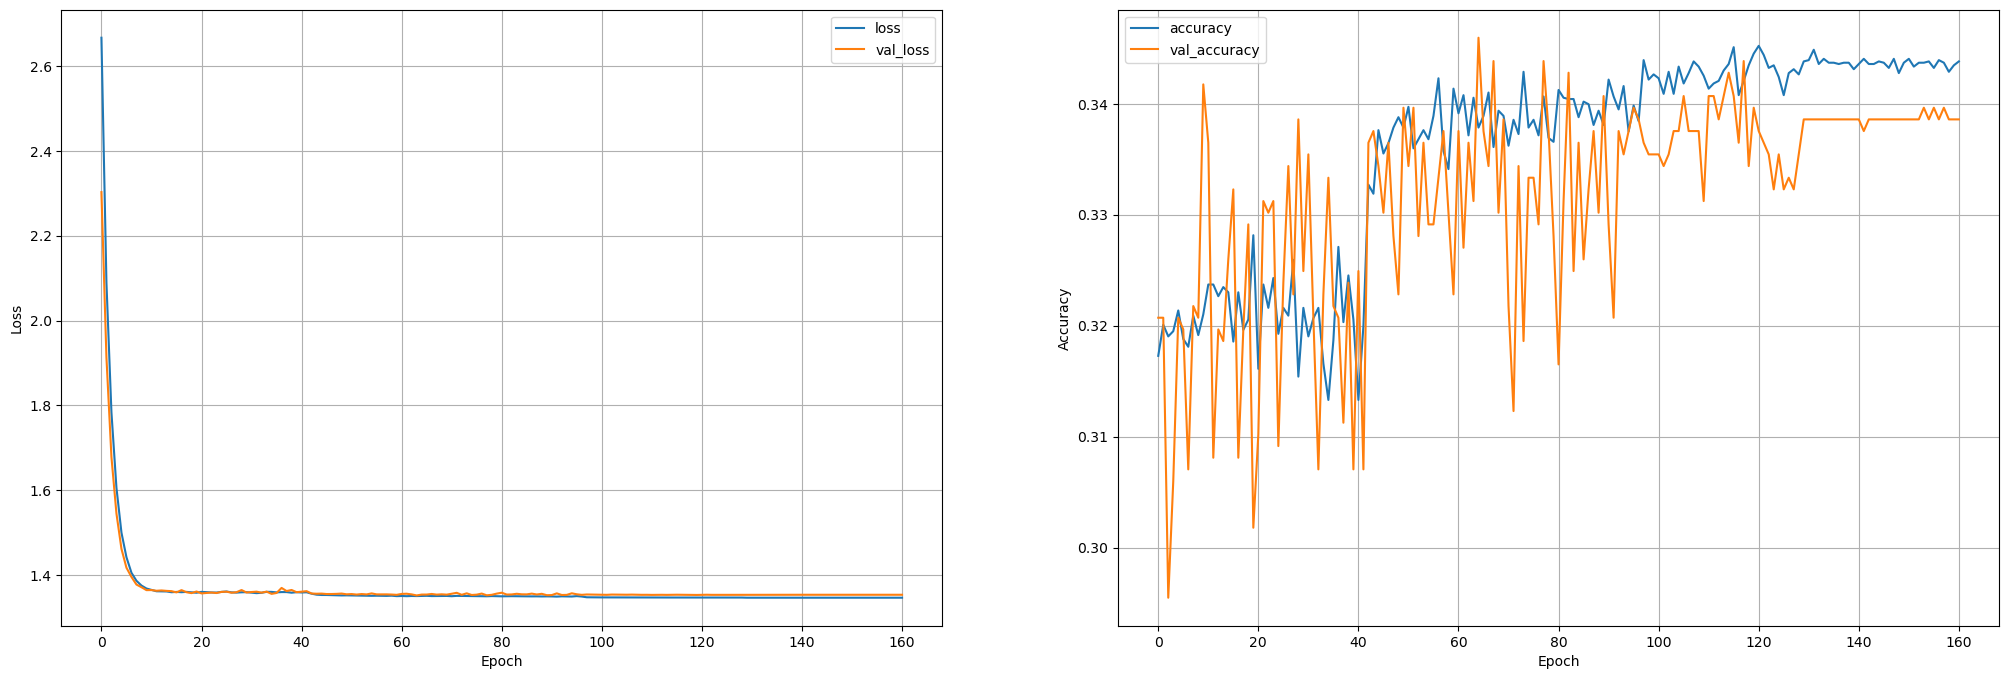

In [28]:
eda_model = tf.keras.Sequential([
    BaseDense(256),
    layers.ReLU(),
    BaseDense(256),
    layers.ReLU(),
    BaseDense(256),
    layers.ReLU(),
    layers.Dense(4, activation='softmax')
])

eda_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

h = eda_model.fit(
    eda_data_train,
    labels_train,
    epochs=1000,
    batch_size=64,
    validation_data=(eda_data_validation, labels_validation),
    callbacks=[early_stop, reduce_lr_cb]
)

plot_results(h)

In [29]:
eda_predictions = np.argmax(eda_model.predict(eda_data_test), axis=1)

eda_cr = classification_report(labels_test, eda_predictions, target_names=unique_labels, zero_division=0, digits=4, output_dict=True)
print(classification_report(labels_test, eda_predictions, target_names=unique_labels, zero_division=0, digits=4))

34/34 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

  Ekscytacja     0.2827    0.3518    0.3135       307
  Odprezenie     0.0000    0.0000    0.0000       181
      Smutek     0.3354    0.6342    0.4388       339
       Zlosc     0.2353    0.0348    0.0606       230

    accuracy                         0.3132      1057
   macro avg     0.2134    0.2552    0.2032      1057
weighted avg     0.2409    0.3132    0.2450      1057



# Combined

Epoch 1/1000
134/134 [==============================] - 1s 5ms/step - loss: 2.6866 - accuracy: 0.3130 - val_loss: 2.3159 - val_accuracy: 0.3207 - lr: 0.1000
Epoch 2/1000
134/134 [==============================] - 0s 4ms/step - loss: 2.0979 - accuracy: 0.3166 - val_loss: 1.9145 - val_accuracy: 0.3207 - lr: 0.1000
Epoch 3/1000
134/134 [==============================] - 0s 4ms/step - loss: 1.7871 - accuracy: 0.3165 - val_loss: 1.6829 - val_accuracy: 0.3165 - lr: 0.1000
Epoch 4/1000
134/134 [==============================] - 0s 4ms/step - loss: 1.6067 - accuracy: 0.3276 - val_loss: 1.5466 - val_accuracy: 0.3091 - lr: 0.1000
Epoch 5/1000
134/134 [==============================] - 0s 4ms/step - loss: 1.5002 - accuracy: 0.3284 - val_loss: 1.4744 - val_accuracy: 0.3102 - lr: 0.1000
Epoch 6/1000
134/134 [==============================] - 0s 4ms/step - loss: 1.4394 - accuracy: 0.3350 - val_loss: 1.4315 - val_accuracy: 0.3049 - lr: 0.1000
Epoch 7/1000
134/134 [==============================] - 0s

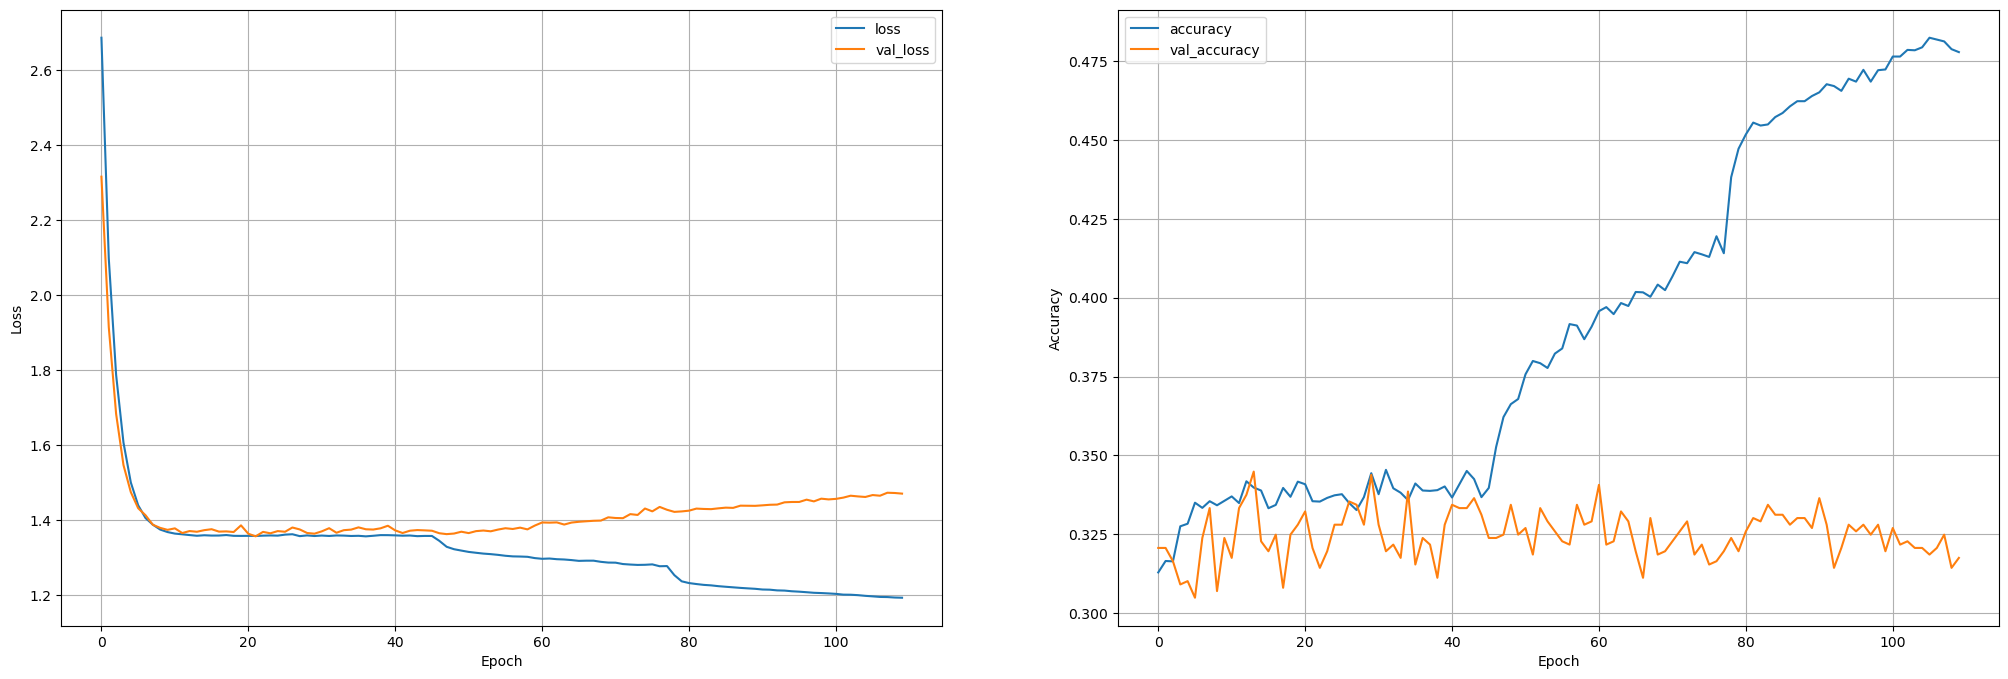

In [30]:
model = tf.keras.Sequential([
    BaseDense(256),
    layers.ReLU(),
    BaseDense(256),
    layers.ReLU(),
    BaseDense(256),
    layers.ReLU(),
    layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

h = model.fit(
    data_train,
    labels_train,
    epochs=1000,
    batch_size=64,
    validation_data=(data_validation, labels_validation),
    callbacks=[early_stop, reduce_lr_cb]
)

plot_results(h)

In [31]:
predictions = np.argmax(model.predict(data_test), axis=1)

cr = classification_report(labels_test, predictions, target_names=unique_labels, zero_division=0, digits=4, output_dict=True)
print(classification_report(labels_test, predictions, target_names=unique_labels, zero_division=0, digits=4))

34/34 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

  Ekscytacja     0.3073    0.5505    0.3944       307
  Odprezenie     0.4444    0.0221    0.0421       181
      Smutek     0.3735    0.5487    0.4444       339
       Zlosc     0.0000    0.0000    0.0000       230

    accuracy                         0.3396      1057
   macro avg     0.2813    0.2803    0.2202      1057
weighted avg     0.2851    0.3396    0.2643      1057



# Summary

In [32]:
print(f'''
  Accuracy:
ECG:\t{ecg_cr['accuracy']:.4f}
EDA:\t{eda_cr['accuracy']:.4f}
Both:\t{cr['accuracy']:.4f}
  Average F1:
ECG:\t{ecg_cr['macro avg']['f1-score']:.4f}
EDA:\t{eda_cr['macro avg']['f1-score']:.4f}
Both:\t{cr['macro avg']['f1-score']:.4f}
  Weighted F1:
ECG:\t{ecg_cr['weighted avg']['f1-score']:.4f}
EDA:\t{eda_cr['weighted avg']['f1-score']:.4f}
Both:\t{cr['weighted avg']['f1-score']:.4f}
''')


  Accuracy:
ECG:	0.3283
EDA:	0.3132
Both:	0.3396
  Average F1:
ECG:	0.1390
EDA:	0.2032
Both:	0.2202
  Weighted F1:
ECG:	0.1763
EDA:	0.2450
Both:	0.2643

